# Mixture Density Networks: Modeling Stellar Lithium Abundance

*Tutorial by Yuan-Sen Ting (ting.74@osu.edu)*

*Companion material for Chapter 15 of the textbook*
  
*If you find this tutorial useful, please cite the accompanying textbook:*

*[Statistical Machine Learning for Astronomy](https://arxiv.org/abs/2506.12230)*

*© 2025 Yuan-Sen Ting. All rights reserved. This tutorial may be redistributed by sharing the original [GitHub repository link](https://github.com/tingyuansen/statml) for educational purposes. Any other reproduction or adaptation requires explicit permission from the author.*


## Introduction

In our study of neural networks, we've explored their remarkable ability to learn complex mappings between inputs and outputs. However, many astronomical relationships exhibit not just complexity but also intrinsic scatter—physical variation that cannot be reduced to a single deterministic function. Traditional neural networks, which output point estimates, fundamentally cannot capture this aspect of the data.

Consider the lithium abundance in stellar atmospheres. Lithium, being a fragile element destroyed at relatively low temperatures, serves as a sensitive probe of stellar interior physics. The surface lithium abundance A(Li) depends primarily on the effective temperature $T_{\rm eff}$ and age τ of a star—cooler and older stars show greater depletion as convective mixing brings surface material to depths where lithium burns. Yet even among stars of identical temperature and age, lithium abundances can vary by orders of magnitude.

This scatter is not measurement error but reflects genuine physical diversity. The depth of convective zones varies stochastically during stellar formation. Pre-main-sequence accretion history differs between stars. The initial lithium abundance itself varies due to the stochastic nature of lithium production in previous stellar generations. These physical processes ensure that the relationship between stellar parameters and lithium abundance is fundamentally probabilistic:

$$p(\text{A(Li)} | T_{\text{eff}}, \tau)$$

rather than deterministic:

$$\text{A(Li)} = f(T_{\text{eff}}, \tau)$$

Mixture Density Networks (MDNs) embrace this probabilistic nature by combining neural networks with mixture models. Instead of predicting a single lithium abundance for given stellar parameters, an MDN outputs the parameters of a probability distribution—specifically, a mixture of Gaussians. Each Gaussian component can capture a different mode in the lithium distribution, such as the populations of lithium-normal and lithium-depleted stars observed in open clusters.

This approach transforms our regression problem into one of conditional density estimation. The neural network learns how the entire probability distribution of lithium abundance varies with stellar parameters, capturing both the mean trends and the intrinsic scatter. By modeling $p(\mathbf{y}|\mathbf{x})$ directly, MDNs provide a complete statistical description of the relationship, enabling uncertainty quantification and revealing the multimodal structures that deterministic models would miss entirely.


## Prerequisites and Learning Objectives

### Foundational Knowledge

This tutorial assumes familiarity with:
- **Python Programming**: Proficiency with NumPy arrays, matplotlib visualization, and PyTorch basics including tensors and automatic differentiation
- **Neural Networks**: Understanding of feedforward networks, activation functions, backpropagation, and gradient-based optimization
- **Probability Theory**: Knowledge of probability distributions, particularly Gaussian distributions and mixture models
- **Statistical Concepts**: Familiarity with maximum likelihood estimation, conditional probability, and the distinction between aleatoric and epistemic uncertainty

### Learning Outcomes

Through this tutorial, you will develop practical skills in:
- **Probabilistic Modeling**: Constructing neural networks that output probability distributions rather than point estimates, capturing both predictive uncertainty and intrinsic scatter
- **Mixture Models**: Understanding how Gaussian mixture models can represent complex, multimodal distributions and their parameterization through neural networks
- **Conditional Density Estimation**: Learning to model how entire probability distributions vary with input conditions, moving beyond simple regression
- **Implementation Techniques**: Mastering the practical aspects of MDN implementation, including output constraints, numerical stability, and gradient-based optimization
- **Scientific Interpretation**: Extracting meaningful insights from predicted distributions, distinguishing between different sources of scatter in astronomical data

We begin with a pedagogical example—the two-moons dataset—to build intuition for multimodal relationships before applying MDNs to the astrophysically rich problem of stellar lithium abundances.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
from sklearn.datasets import make_moons

# Configure plotting parameters for publication-quality figures
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['font.size'] = 20
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 20

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

%matplotlib inline

## A Pedagogical Example: The Two-Moons Dataset

Before delving into the complexities of stellar lithium abundance, we'll build intuition using a simple but instructive dataset—the two-moons configuration. This synthetic dataset exemplifies a fundamental challenge in regression: relationships where a single input corresponds to multiple possible outputs.

The two-moons dataset consists of two interleaving half-circles, creating a configuration where traditional regression fails catastrophically. For many x-coordinates, there exist two distinct y-values corresponding to the upper and lower crescents. This one-to-many mapping cannot be captured by any deterministic function $y = f(x)$, no matter how complex.

This limitation isn't merely technical—it reflects a fundamental mismatch between the model and the data. A standard neural network, forced to output a single y-value for each x, will typically predict the average of the two modes, placing its predictions in the empty space between the moons where no data actually exists. This averaging behavior, while minimizing mean squared error, completely fails to capture the true structure of the data.

The two-moons dataset thus provides an ideal testbed for understanding why probabilistic approaches are essential. Just as stars of identical temperature and age can have different lithium abundances due to varied formation histories, points at the same $x$-coordinate can have different $y$-values due to the geometric structure of the moons. In both cases, we need models that can represent multiple possibilities rather than collapsing to a single prediction.

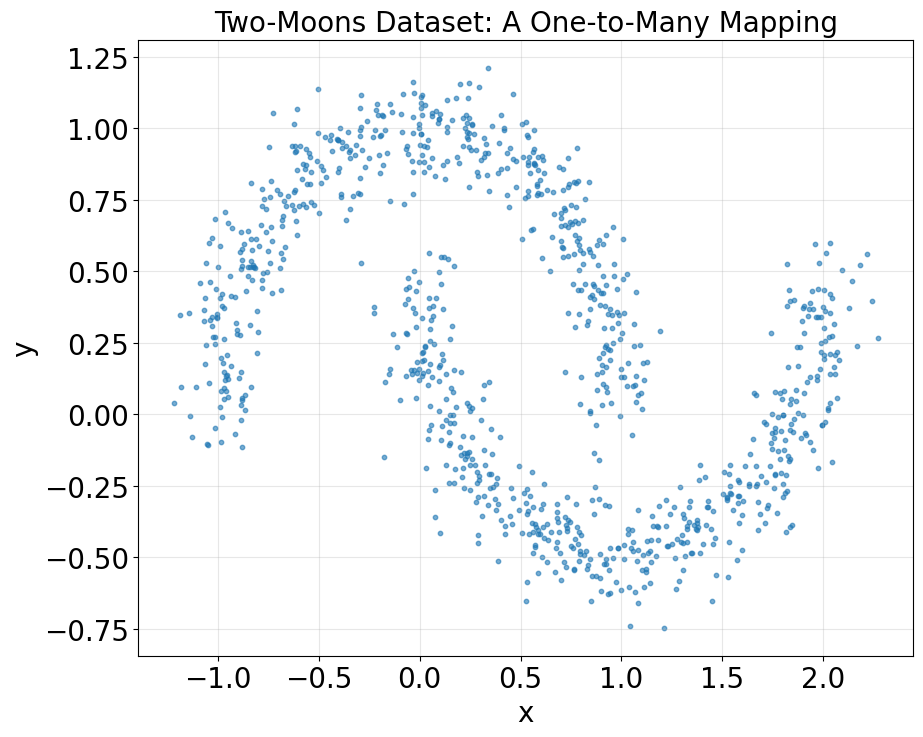

In [2]:
# Generate moon-shaped data with added noise for realism
X, _ = make_moons(n_samples=1000, noise=0.1, random_state=42)

# Extract x and y coordinates for clarity
x_train = X[:, 0]
y_train = X[:, 1]

# Visualize the two-moons dataset
plt.figure(figsize=(10, 8))
plt.scatter(x_train, y_train, s=10, alpha=0.6)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Two-Moons Dataset: A One-to-Many Mapping')
plt.grid(True, alpha=0.3)
plt.show()

## The Mathematical Framework of Mixture Density Networks

The core insight of Mixture Density Networks lies in replacing point predictions with probability distributions. Rather than learning a function $\mathbf{y} = f(\mathbf{x})$, an MDN learns the conditional probability distribution $p(\mathbf{y}|\mathbf{x})$. This fundamental shift enables the model to capture both multimodality and intrinsic scatter in the data.

### Gaussian Mixture Models as Output Distributions

An MDN models the conditional distribution as a mixture of Gaussians:

$$p(\mathbf{y}|\mathbf{x}) = \sum_{k=1}^K \pi_k(\mathbf{x}) \mathcal{N}(\mathbf{y}|\boldsymbol{\mu}_k(\mathbf{x}), \boldsymbol{\Sigma}_k(\mathbf{x}))$$

Each component of this mixture is characterized by three parameters that vary as functions of the input $\mathbf{x}$:

1. **Mixing coefficients** $\pi_k(\mathbf{x})$: The relative weight of each Gaussian component, satisfying $\sum_k \pi_k(\mathbf{x}) = 1$
2. **Means** $\boldsymbol{\mu}_k(\mathbf{x})$: The center of each Gaussian component
3. **Covariances** $\boldsymbol{\Sigma}_k(\mathbf{x})$: The spread and shape of each component (often simplified to diagonal or spherical covariances)

The key innovation is that these parameters are not fixed but are computed by a neural network as functions of the input. This allows the distribution to vary smoothly across the input space, adapting its shape to capture local patterns in the data.

### Network Architecture and Output Constraints

For a mixture with $K$ components predicting $D$-dimensional outputs, the neural network must produce:
- $K$ mixing coefficients (constrained to form a valid probability distribution)
- $K \times D$ mean values (unconstrained)
- Covariance parameters (constrained to ensure positive definiteness)

The architecture follows a standard feedforward design until the output layer, where we must carefully handle the constraints. The mixing coefficients require a softmax transformation to ensure they sum to unity:

$$\pi_k(\mathbf{x}) = \frac{\exp(z_k(\mathbf{x}))}{\sum_{j=1}^K \exp(z_j(\mathbf{x}))}$$

where $z_k(\mathbf{x})$ are the raw network outputs for the mixing coefficients. For simplicity in this tutorial, we'll work with diagonal covariances, requiring only variance parameters $\sigma_k^2(\mathbf{x})$ that we constrain to be positive through the exponential function.

In [3]:
class MDN(nn.Module):
    """
    Mixture Density Network for conditional density estimation.
    
    Parameters
    ----------
    n_inputs : int
        Dimensionality of input features
    n_hidden : int
        Number of neurons in hidden layers
    n_gaussians : int
        Number of Gaussian components in the mixture
    """
    def __init__(self, n_inputs=1, n_hidden=20, n_gaussians=2):
        super().__init__()
        
        self.n_gaussians = n_gaussians
        
        # Standard feedforward architecture for feature extraction
        self.fc1 = nn.Linear(n_inputs, n_hidden)
        self.fc2 = nn.Linear(n_hidden, n_hidden)
        
        # Output layer produces parameters for K Gaussian components:
        # - K mixing coefficients π_k
        # - K means μ_k
        # - K standard deviations σ_k
        self.fc3 = nn.Linear(n_hidden, n_gaussians * 3)
        
    def forward(self, x):
        # Extract features through hidden layers
        h = torch.relu(self.fc1(x))
        h = torch.relu(self.fc2(h))
        
        # Generate mixture parameters
        params = self.fc3(h)
        
        # Split parameters by component type
        mu = params[:, :self.n_gaussians]
        log_sigma = params[:, self.n_gaussians:2*self.n_gaussians]
        logit_pi = params[:, 2*self.n_gaussians:]
        
        # Apply constraints to ensure valid distributions
        sigma = torch.exp(log_sigma)  # Ensure positive standard deviations
        pi = torch.softmax(logit_pi, dim=1)  # Ensure mixing coefficients sum to 1
        
        return mu, sigma, pi

## Training Mixture Density Networks

The training objective for MDNs follows directly from the principle of maximum likelihood estimation. Given a dataset of input-output pairs $\{(\mathbf{x}_n, \mathbf{y}_n)\}_{n=1}^N$, we seek network parameters $\mathbf{w}$ that maximize the likelihood of observing our data under the predicted distributions:

$$\mathcal{L}(\mathbf{w}) = \prod_{n=1}^N p(\mathbf{y}_n|\mathbf{x}_n, \mathbf{w})$$

Taking the logarithm converts this product into a sum, yielding the log-likelihood objective:

$$\log \mathcal{L}(\mathbf{w}) = \sum_{n=1}^N \log \left[ \sum_{k=1}^K \pi_k(\mathbf{x}_n) \mathcal{N}(\mathbf{y}_n|\mu_k(\mathbf{x}_n), \sigma_k^2(\mathbf{x}_n)) \right]$$

In practice, we minimize the negative log-likelihood, which serves as our loss function. This formulation naturally handles the mixture structure—the inner sum combines probabilities from all Gaussian components, while the logarithm prevents numerical underflow when dealing with small probability values.

The gradient-based optimization proceeds identically to standard neural network training, with backpropagation computing gradients through both the mixture parameters and the underlying neural network weights. The key difference lies in the loss function, which evaluates how well our predicted probability distributions explain the observed data rather than measuring deviation from point predictions.

In [4]:
def mdn_loss_fn(y_true, mu, sigma, pi):
    """
    Negative log-likelihood loss for Mixture Density Networks.
    
    Parameters
    ----------
    y_true : torch.Tensor
        True output values, shape (batch_size, 1)
    mu : torch.Tensor
        Predicted means for each component, shape (batch_size, n_gaussians)
    sigma : torch.Tensor
        Predicted standard deviations, shape (batch_size, n_gaussians)
    pi : torch.Tensor
        Mixing coefficients, shape (batch_size, n_gaussians)
        
    Returns
    -------
    loss : torch.Tensor
        Negative log-likelihood averaged over the batch
    """
    # Create Gaussian distributions for each component
    gaussians = torch.distributions.Normal(mu, sigma)
    
    # Compute log probabilities under each component
    log_prob = gaussians.log_prob(y_true)
    
    # Weight by mixing coefficients and sum across components
    # Use log-sum-exp trick for numerical stability
    weighted_log_prob = log_prob + torch.log(pi)
    log_likelihood = torch.logsumexp(weighted_log_prob, dim=1)
    
    # Return mean negative log-likelihood
    return -torch.mean(log_likelihood)

## Application to the Two-Moons Dataset

With our MDN architecture and loss function defined, we can now train the model on the two-moons dataset. This example will demonstrate how MDNs capture the bimodal structure that deterministic models miss entirely.

First, we prepare our data for training. The MDN requires properly formatted tensors and benefits from mini-batch training for stable optimization:

In [5]:
# Convert data to PyTorch tensors
x = torch.from_numpy(x_train).float().reshape(-1, 1)
y = torch.from_numpy(y_train).float().reshape(-1, 1)

# Create dataset and dataloader for efficient batching
dataset = TensorDataset(x, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Instantiate MDN with 2 Gaussian components
model = MDN(n_inputs=1, n_hidden=20, n_gaussians=2)

# Configure optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training loop
n_epochs = 1000
for epoch in range(n_epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in dataloader:
        # Forward pass
        mu, sigma, pi = model(x_batch)
        loss = mdn_loss_fn(y_batch, mu, sigma, pi)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Report progress
    if epoch % 100 == 0:
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch {epoch:4d}, Loss: {avg_loss:.4f}')

Epoch    0, Loss: 1.0554
Epoch  100, Loss: -0.0266
Epoch  200, Loss: -0.0687
Epoch  300, Loss: -0.0901
Epoch  400, Loss: -0.1081
Epoch  500, Loss: -0.1242
Epoch  600, Loss: -0.1044
Epoch  700, Loss: -0.1278
Epoch  800, Loss: -0.1213
Epoch  900, Loss: -0.1269


## Visualizing the Learned Distributions

After training, we can examine how the MDN has learned to represent the two-moons structure. By generating predictions across the input range and visualizing the predicted Gaussian components, we can see how the model captures the bimodal nature of the data.

The visualization reveals several key aspects of the MDN's behavior:
1. How the means of the Gaussian components track the upper and lower moons
2. How the standard deviations adapt to the local data density
3. How the mixing coefficients shift to emphasize different components across the input space

This adaptive behavior—where the entire distribution changes as a function of the input—is what enables MDNs to capture complex, multimodal relationships that would be impossible for deterministic models.

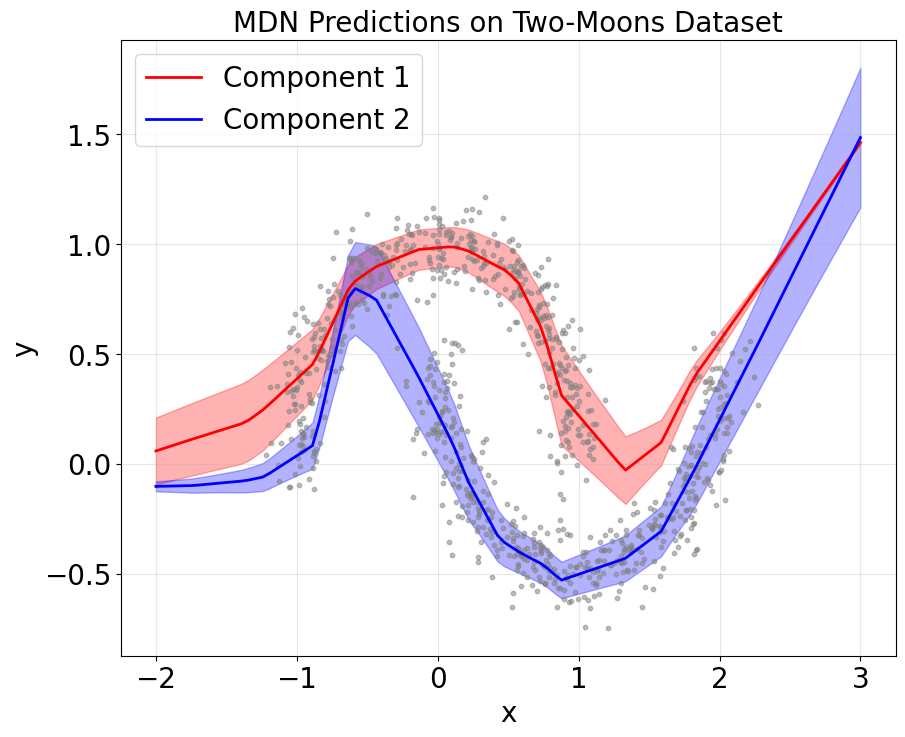

In [6]:
# Generate predictions across the input range
x_test = torch.linspace(-2, 3, 100).reshape(-1, 1)
mu_pred, sigma_pred, pi_pred = model(x_test)

# Convert to numpy for plotting
x_test_np = x_test.detach().numpy()
mu_pred_np = mu_pred.detach().numpy()
sigma_pred_np = sigma_pred.detach().numpy()
pi_pred_np = pi_pred.detach().numpy()

# Visualize the predicted Gaussian components
plt.figure(figsize=(10, 8))

# Plot each Gaussian component
colors = ['red', 'blue']
for k in range(2):
    # Plot mean
    plt.plot(x_test_np, mu_pred_np[:, k], color=colors[k], 
             label=f'Component {k+1}', linewidth=2)
    
    # Plot ±1σ confidence bands
    plt.fill_between(x_test_np.ravel(),
                     mu_pred_np[:, k] - sigma_pred_np[:, k],
                     mu_pred_np[:, k] + sigma_pred_np[:, k],
                     alpha=0.3, color=colors[k])

# Overlay the original data
plt.scatter(x_train, y_train, s=10, alpha=0.5, color='gray')

plt.xlabel('x')
plt.ylabel('y')
plt.title('MDN Predictions on Two-Moons Dataset')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

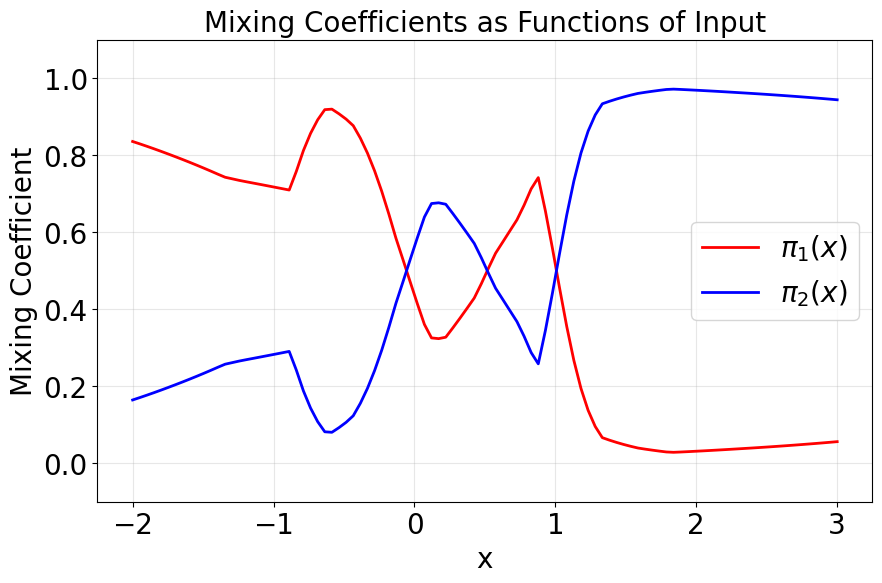

In [7]:
# Visualize how mixing coefficients vary with input
plt.figure(figsize=(10, 6))

for k in range(2):
    plt.plot(x_test_np, pi_pred_np[:, k], color=colors[k], 
             label=r'$\pi_{}(x)$'.format(k+1), linewidth=2)

plt.xlabel('x')
plt.ylabel('Mixing Coefficient')
plt.title('Mixing Coefficients as Functions of Input')
plt.legend()
plt.grid(True, alpha=0.3)
plt.ylim(-0.1, 1.1)
plt.show()

## Stellar Lithium Abundance: A Case Study in Astrophysical Scatter

Having established the conceptual and mathematical foundations of MDNs, we now turn to a compelling astrophysical application: modeling the lithium abundance in stellar atmospheres. This problem exemplifies why probabilistic approaches are essential in astronomy—the relationship between stellar parameters and lithium abundance exhibits both systematic trends and substantial intrinsic scatter that cannot be reduced to measurement error.

### The Astrophysical Context

Lithium occupies a unique position in stellar astrophysics as one of the most fragile elements in stellar interiors. With a burning temperature of only 2.5 × 10⁶ K, lithium is readily destroyed when convective mixing brings surface material to the hot stellar interior. This fragility makes lithium abundance a sensitive probe of stellar structure and evolution.

The surface lithium abundance A(Li) depends primarily on two stellar parameters:

1. **Effective Temperature ($T_{\text{eff}}$)**: Cooler stars possess deeper convective zones, leading to more efficient lithium depletion as surface material circulates to greater depths where nuclear burning occurs.

2. **Age ($\tau$)**: Lithium depletion is a gradual process. Older stars have had more time to destroy their primordial lithium through convective mixing, resulting in lower surface abundances.

Yet even among stars with identical temperatures and ages, lithium abundances can vary by orders of magnitude. This scatter reflects genuine physical diversity rather than observational uncertainty. Contributing factors include:

- **Pre-main-sequence evolution**: Variations in accretion history and disk lifetimes lead to different initial conditions
- **Convective zone depth**: Small differences in stellar structure parameters produce significant variations in mixing efficiency
- **Initial composition**: The stochastic nature of lithium production in previous stellar generations creates primordial abundance variations
- **Angular momentum evolution**: Rotation and magnetic fields influence convective mixing patterns

These physical processes ensure that the relationship between stellar parameters and lithium abundance is fundamentally probabilistic, making it an ideal target for MDN modeling.

### Open Clusters: Natural Laboratories for Stellar Evolution

Our dataset derives from observations of four open star clusters, which provide ideal laboratories for studying lithium depletion. Open clusters are gravitationally bound groups of stars that formed from the same molecular cloud, ensuring that cluster members share:

- **Common age**: All stars formed within a few million years of each other
- **Common initial composition**: Stars inherited the same primordial abundances from their parent cloud
- **Minimal environmental differences**: Similar dynamical histories and external influences

These shared properties eliminate many confounding variables that complicate field star studies. Most critically, cluster membership allows precise age determination through isochrone fitting—a technique unavailable for isolated field stars where individual ages remain highly uncertain.

By combining data from multiple clusters spanning different ages, we can trace how lithium depletion evolves over cosmic time while maintaining tight control over the age variable. This controlled sampling reveals both the systematic trends and intrinsic scatter in lithium evolution, providing an ideal dataset for demonstrating the power of probabilistic modeling with MDNs.

Let's examine the lithium abundance patterns in our cluster sample:

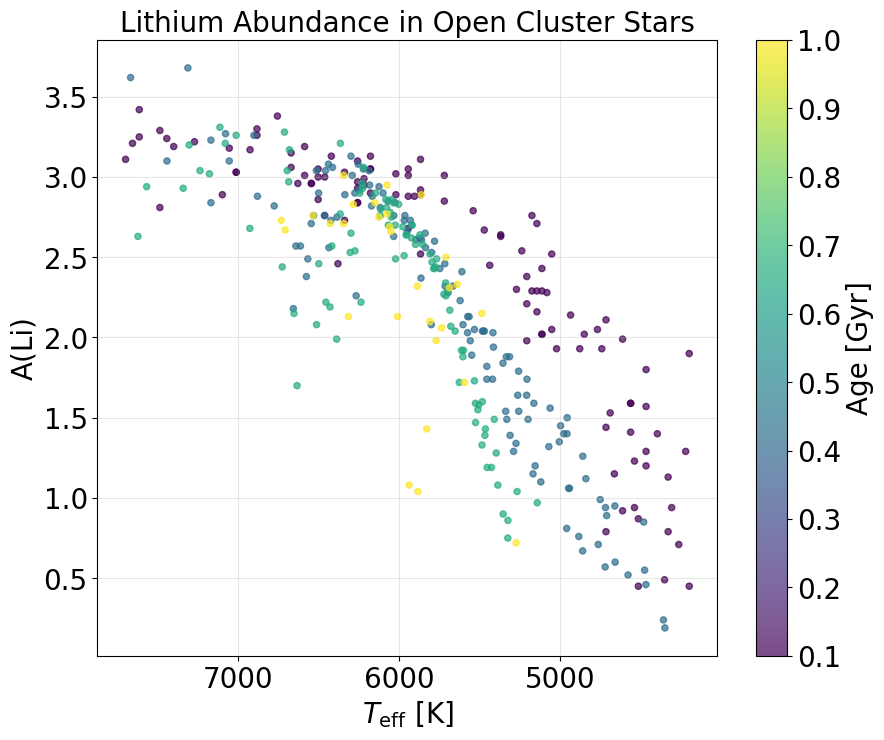

Dataset contains 358 stars
Temperature range: 4199 - 7700 K
Age range: 0.10 - 1.00 Gyr
A(Li) range: 0.19 - 3.68 dex


In [8]:
# Load the lithium abundance dataset from open clusters
data = np.load('dataset_lithium_abundance.npz')

# Extract stellar parameters and lithium abundance
age = data['age']      # Stellar age in Gyr
teff = data['teff']    # Effective temperature in K
ALi = data['ALi']      # Lithium abundance A(Li)

# Visualize the lithium depletion patterns
plt.figure(figsize=(10, 8))

# Create scatter plot with age-based coloring
scatter = plt.scatter(teff, ALi, c=age, cmap='viridis', s=20, alpha=0.7)

# Add colorbar to show age mapping
cbar = plt.colorbar(scatter)
cbar.set_label('Age [Gyr]')

plt.xlabel(r'$T_{\rm eff}$ [K]')
plt.ylabel('A(Li)')
plt.title('Lithium Abundance in Open Cluster Stars')
plt.grid(True, alpha=0.3)

# Invert x-axis (astronomical convention: hot stars on left)
plt.gca().invert_xaxis()

plt.show()

# Print summary statistics
print(f"Dataset contains {len(teff)} stars")
print(f"Temperature range: {teff.min():.0f} - {teff.max():.0f} K")
print(f"Age range: {age.min():.2f} - {age.max():.2f} Gyr")
print(f"A(Li) range: {ALi.min():.2f} - {ALi.max():.2f} dex")

## Modeling Lithium Abundance with MDNs

The scatter plot reveals the complex relationship between stellar parameters and lithium abundance. Several features stand out:

1. **Temperature Dependence**: A clear trend of decreasing lithium with decreasing temperature, reflecting the deeper convective zones in cooler stars
2. **Age Evolution**: At fixed temperature, older stars (darker points) show systematically lower lithium abundances
3. **Intrinsic Scatter**: Even at fixed temperature and age, substantial scatter remains—sometimes exceeding an order of magnitude

This scatter is not observational noise but reflects genuine astrophysical diversity. A deterministic model would average over this scatter, losing crucial information about the distribution of lithium abundances. Instead, we need a model that can capture the full conditional distribution:

$$p(\text{A(Li)} | T_{\text{eff}}, \tau)$$

An MDN is ideally suited for this task. By predicting a mixture of Gaussians for each combination of temperature and age, the model can:
- Capture the mean depletion trends
- Quantify the intrinsic scatter at each point in parameter space
- Potentially identify multiple populations (e.g., lithium-normal and lithium-poor stars)

Let's prepare our data and train an MDN to model these complex relationships:

In [9]:
# Prepare input features: temperature and age
X = np.column_stack([teff, age])
y = ALi.reshape(-1, 1)

# Normalize temperature to similar scale as age (in units of 1000 K)
X[:, 0] /= 1000.0

# Convert to PyTorch tensors
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# Create dataset and dataloader
dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize MDN with more components to capture complexity
model = MDN(n_inputs=2, n_hidden=50, n_gaussians=5)

# Configure optimizer with lower learning rate for stability
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
n_epochs = 5000
print("Training MDN on lithium abundance data...")

for epoch in range(n_epochs):
    epoch_loss = 0.0
    for x_batch, y_batch in dataloader:
        # Forward pass
        mu, sigma, pi = model(x_batch)
        loss = mdn_loss_fn(y_batch, mu, sigma, pi)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    # Report progress
    if epoch % 500 == 0:
        avg_loss = epoch_loss / len(dataloader)
        print(f'Epoch {epoch:4d}, Loss: {avg_loss:.4f}')

Training MDN on lithium abundance data...
Epoch    0, Loss: 3.6973
Epoch  500, Loss: 0.4385
Epoch 1000, Loss: 0.3406
Epoch 1500, Loss: 0.3252
Epoch 2000, Loss: 0.2282
Epoch 2500, Loss: 0.1956
Epoch 3000, Loss: 0.1599
Epoch 3500, Loss: 0.1419
Epoch 4000, Loss: 0.1233
Epoch 4500, Loss: 0.1175


## Visualizing Lithium Evolution Across Parameter Space

With our trained MDN, we can now explore how the predicted lithium distribution varies across the temperature-age parameter space. Rather than obtaining single predictions, the MDN provides complete probability distributions at each point, enabling us to visualize both the mean evolutionary trends and the intrinsic scatter.

To comprehensively understand the model's behavior, we'll create two complementary visualizations:

1. **Mean Lithium Evolution**: How the expected lithium abundance varies with temperature for different stellar ages
2. **Scatter Patterns**: How the intrinsic spread in lithium abundance changes across parameter space

These visualizations reveal insights that would be impossible with deterministic models. The mean trends show the systematic depletion patterns, while the scatter maps highlight regions of enhanced diversity—potentially indicating transitions between different depletion mechanisms or the presence of multiple stellar populations.

For each point in parameter space, we'll sample from the predicted mixture distribution to estimate both the mean abundance and the standard deviation. This sampling approach properly accounts for the multimodal nature of the predictions, providing more accurate statistics than simply examining individual Gaussian components.

In [10]:
# Create grid of ages for visualization
age_grid = np.linspace(0.1, 1.0, 20)
teff_grid = np.linspace(4.0, 7.0, 100)  # in units of 1000 K

# Storage for predictions
mean_ALi = []
scatter_ALi = []

# Generate predictions for each age
with torch.no_grad():
    for age_val in age_grid:
        # Create temperature grid at fixed age
        X_pred = torch.zeros((len(teff_grid), 2))
        X_pred[:, 0] = torch.tensor(teff_grid)
        X_pred[:, 1] = age_val
        
        # Get MDN predictions
        mu, sigma, pi = model(X_pred)
        
        # Sample from mixture to estimate mean and scatter
        age_means = []
        age_stds = []
        
        for i in range(len(teff_grid)):
            # Sample from the mixture distribution
            samples = []
            for k in range(model.n_gaussians):
                # Number of samples proportional to mixing coefficient
                n_samples = int(10000 * pi[i, k].item())
                if n_samples > 0:
                    component_samples = np.random.normal(
                        mu[i, k].item(), 
                        sigma[i, k].item(), 
                        n_samples
                    )
                    samples.extend(component_samples)
            
            samples = np.array(samples)
            age_means.append(np.mean(samples))
            age_stds.append(np.std(samples))
        
        mean_ALi.append(age_means)
        scatter_ALi.append(age_stds)

mean_ALi = np.array(mean_ALi)
scatter_ALi = np.array(scatter_ALi)

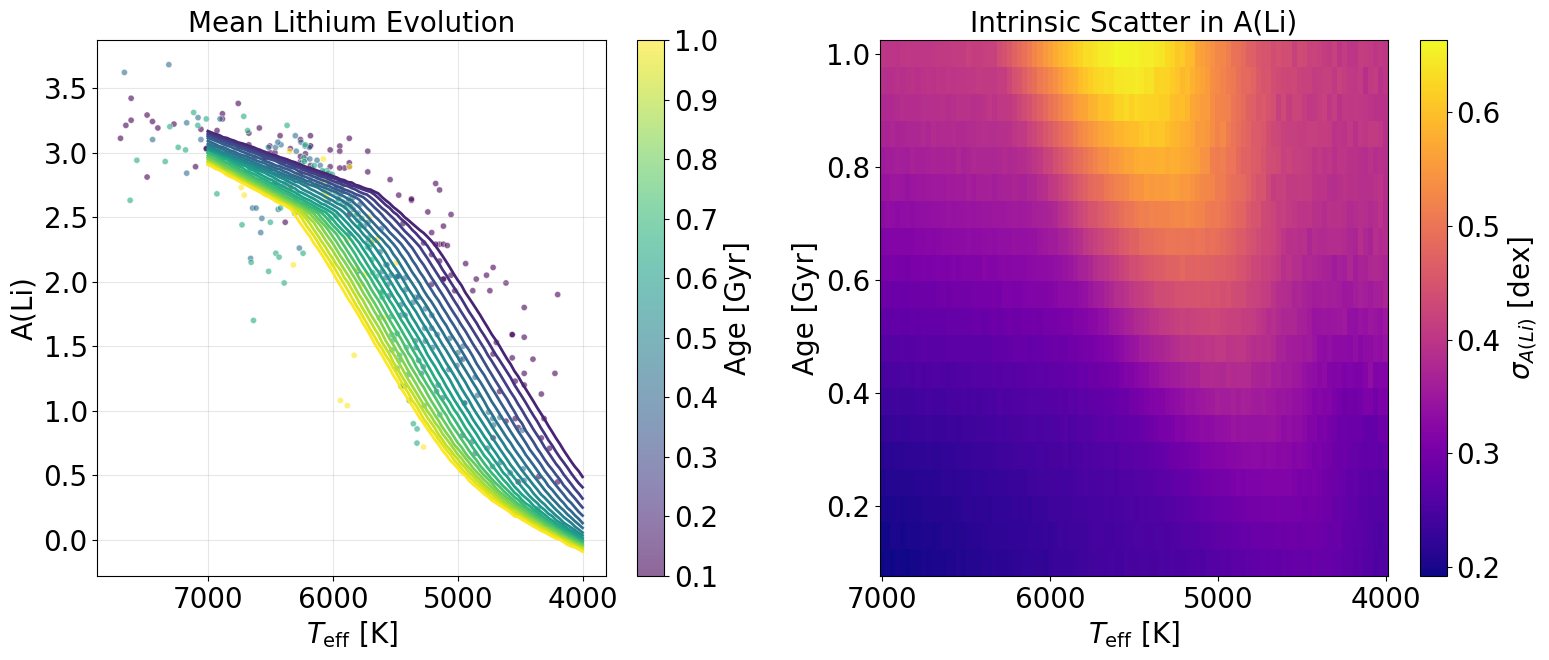

In [11]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left panel: Mean lithium evolution
cmap = plt.cm.viridis
for i, age_val in enumerate(age_grid):
    color = cmap(age_val)
    ax1.plot(teff_grid * 1000, mean_ALi[i], color=color, linewidth=2)

# Overlay observed data
scatter1 = ax1.scatter(teff, ALi, c=age, cmap='viridis', s=20, 
                       alpha=0.6, edgecolors='white', linewidth=0.5)
ax1.set_xlabel(r'$T_{\rm eff}$ [K]')
ax1.set_ylabel('A(Li)')
ax1.set_title('Mean Lithium Evolution')
ax1.grid(True, alpha=0.3)
ax1.invert_xaxis()

# Add colorbar for age
cbar1 = plt.colorbar(scatter1, ax=ax1)
cbar1.set_label('Age [Gyr]')

# Right panel: Scatter in predictions
# Create 2D plot of scatter as function of Teff and age
teff_mesh, age_mesh = np.meshgrid(teff_grid * 1000, age_grid)
im = ax2.pcolormesh(teff_mesh, age_mesh, scatter_ALi, 
                    cmap='plasma', shading='auto')

ax2.set_xlabel(r'$T_{\rm eff}$ [K]')
ax2.set_ylabel('Age [Gyr]')
ax2.set_title('Intrinsic Scatter in A(Li)')
ax2.invert_xaxis()

# Add colorbar for scatter
cbar2 = plt.colorbar(im, ax=ax2)
cbar2.set_label(r'$\sigma_{A(Li)}$ [dex]')

plt.tight_layout()
plt.show()

## Physical Interpretation of the Results

The two panels together tell a compelling story about lithium evolution in stars:

### The Mean Evolution (Left Panel)

The left panel beautifully captures the well-known "lithium depletion boundary" and its evolution with age. The key features align with our theoretical understanding:

1. **The Lithium Wall**: Stars hotter than ~6700 K maintain high lithium abundances regardless of age, as their shallow convective zones never reach the lithium burning temperature of 2.5 × 10⁶ K.

2. **The Depletion Cliff**: Between 6500-5500 K, we see a dramatic transition where lithium abundance drops by over 2 orders of magnitude. This steep gradient marks where convective zones become deep enough to mix surface material down to burning temperatures.

3. **Age Stratification**: The parallel tracks for different ages show that lithium depletion is a continuous process throughout stellar lifetimes, with typical depletion rates of ~0.5 dex/Gyr for solar-type stars.

### The Scatter Landscape (Right Panel)

The high scatter values (~0.4-0.6 dex) across much of the parameter space reflect a fundamental truth about stellar astrophysics: lithium abundance is influenced by numerous factors beyond just temperature and age. This substantial intrinsic scatter arises from:

1. **Pre-Main Sequence Diversity**: Stars arrive on the main sequence with different rotation rates, magnetic field strengths, and accretion histories—all affecting their initial lithium content and subsequent depletion rates.

2. **Convective Complexity**: Small variations in stellar mass, metallicity, or initial angular momentum can produce significant differences in convective zone depths and mixing efficiency, leading to order-of-magnitude variations in lithium abundance.

3. **Stochastic Processes**: The scatter suggests that lithium depletion involves inherently stochastic processes that cannot be reduced to simple deterministic relationships.

The relatively uniform scatter across parameter space (rather than concentrated in specific regions) indicates that lithium abundance diversity is a pervasive feature of stellar populations, not limited to transition regions. This validates our choice of probabilistic modeling—deterministic approaches would miss this crucial aspect of stellar evolution.

## Conditional Distributions: Revealing Multimodality

To fully appreciate the probabilistic nature of lithium abundance, let's examine the complete conditional distributions at specific points in parameter space. By visualizing $p(\text{A(Li)}|T_{\text{eff}}, \tau)$ directly, we can see whether the MDN captures genuine multimodality or simply broad unimodal distributions.

This analysis is particularly valuable for understanding the physical diversity within stellar populations. If the conditional distributions show multiple peaks, this could indicate:
- Distinct stellar populations with different lithium depletion histories
- Transitions between different physical regimes (e.g., stars with and without planet engulfment)
- The coexistence of lithium-normal and lithium-depleted stars observed in some open clusters

Let's examine three representative cases spanning different regions of parameter space:

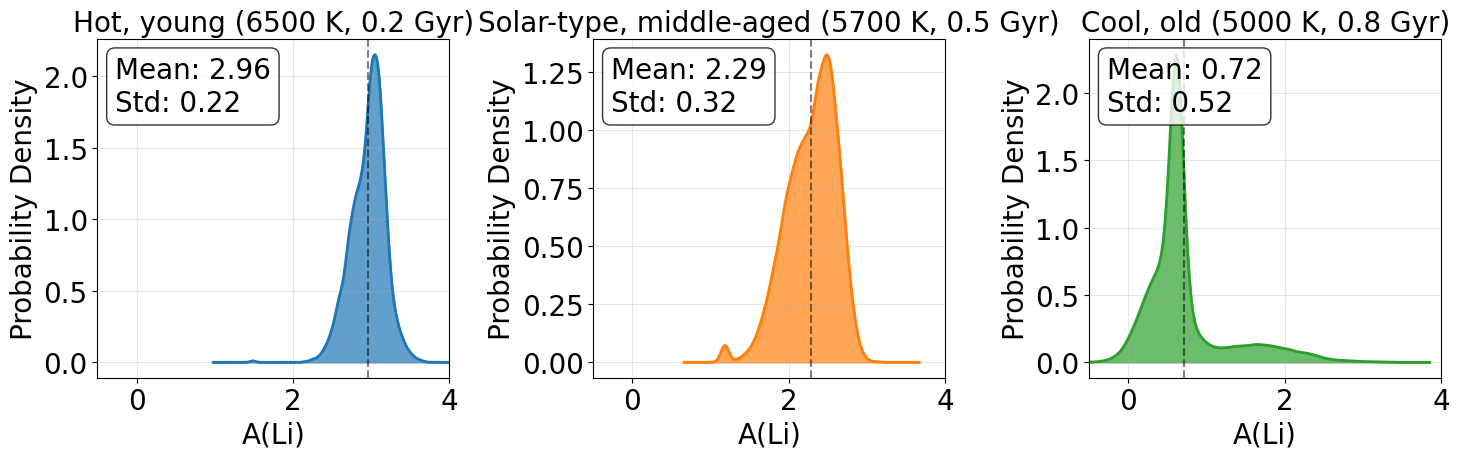

In [12]:
# Select representative stellar parameters
test_cases = [
    {'teff': 6.5, 'age': 0.2, 'label': 'Hot, young (6500 K, 0.2 Gyr)'},
    {'teff': 5.7, 'age': 0.5, 'label': 'Solar-type, middle-aged (5700 K, 0.5 Gyr)'},
    {'teff': 5.0, 'age': 0.8, 'label': 'Cool, old (5000 K, 0.8 Gyr)'}
]

plt.figure(figsize=(15, 5))

for i, case in enumerate(test_cases):
    plt.subplot(1, 3, i+1)
    
    # Create input tensor for this case
    X_case = torch.tensor([[case['teff'], case['age']]], dtype=torch.float32)
    
    # Get MDN predictions
    with torch.no_grad():
        mu, sigma, pi = model(X_case)
    
    # Sample from the mixture distribution
    n_samples = 10000
    samples = []
    
    for k in range(model.n_gaussians):
        # Sample proportionally to mixing coefficient
        n_k = int(n_samples * pi[0, k].item())
        if n_k > 0:
            component_samples = np.random.normal(
                mu[0, k].item(),
                sigma[0, k].item(),
                n_k
            )
            samples.extend(component_samples)
    
    samples = np.array(samples)
    
    # Plot kernel density estimate
    if len(samples) > 0:
        from scipy import stats as scipy_stats
        kde = scipy_stats.gaussian_kde(samples)
        x_range = np.linspace(samples.min() - 0.5, samples.max() + 0.5, 200)
        density = kde(x_range)
        
        plt.fill_between(x_range, density, alpha=0.7, color=f'C{i}')
        plt.plot(x_range, density, linewidth=2, color=f'C{i}')
    
    plt.xlabel('A(Li)')
    plt.ylabel('Probability Density')
    plt.title(case['label'])
    plt.grid(True, alpha=0.3)
    plt.xlim(-0.5, 4.0)
    
    # Add summary statistics
    if len(samples) > 0:
        mean_val = np.mean(samples)
        std_val = np.std(samples)
        plt.axvline(mean_val, color='black', linestyle='--', alpha=0.5)
        plt.text(0.05, 0.95, f'Mean: {mean_val:.2f}\nStd: {std_val:.2f}',
                transform=plt.gca().transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

The three conditional distributions reveal how the nature of lithium scatter evolves across stellar parameter space:

**Hot, Young Stars (6500 K, 0.2 Gyr)**: The distribution shows a relatively narrow peak centered around A(Li) ≈ 3.0, consistent with primordial lithium abundance. The modest scatter (~0.3 dex) reflects primarily the initial conditions—variations in birth environment and pre-main-sequence evolution—rather than depletion processes.

**Solar-Type, Middle-Aged Stars (5700 K, 0.5 Gyr)**: This regime exhibits the broadest distribution, with substantial probability mass spanning over 1.5 dex in lithium abundance. The width of this distribution captures the transition zone where small differences in stellar parameters produce dramatically different depletion rates. Some stars may have experienced enhanced mixing due to planetary engulfment or magnetic activity, while others maintained relatively quiescent evolution.

**Cool, Old Stars (5000 K, 0.8 Gyr)**: The distribution shifts to much lower abundances with a peak around A(Li) ≈ 0.5, representing severe depletion. Interestingly, the distribution remains broad, suggesting that even after gigayears of evolution, diversity persists. This could indicate multiple depletion channels or the influence of additional parameters not captured in our temperature-age model.

These conditional distributions demonstrate the power of MDNs to capture complex astrophysical relationships. Rather than predicting a single "best-fit" lithium abundance, the model provides complete probability distributions that encode both our knowledge and uncertainty. This probabilistic approach aligns naturally with the Bayesian framework that underlies much of modern astrophysics, where quantifying uncertainty is as important as making predictions.

The ability to examine these distributions at any point in parameter space provides a powerful diagnostic tool. Astronomers can use such models to identify interesting targets for follow-up observations (stars in the tails of the distributions), test theoretical predictions (comparing predicted and observed distribution shapes), and properly account for intrinsic scatter in population studies.

## Summary

Mixture Density Networks elegantly address a fundamental limitation of standard neural networks: the inability to capture relationships where a single input corresponds to multiple possible outputs. By combining neural networks with Gaussian mixture models, MDNs transform regression into conditional density estimation, predicting not just values but entire probability distributions.

The power of this approach became clear through our exploration of two contrasting examples. The two-moons dataset provided pedagogical clarity—a simple geometry where deterministic models catastrophically fail by averaging between modes. The stellar lithium abundance problem showcased real scientific complexity, where intrinsic scatter reflects genuine physical diversity rather than measurement error. In both cases, MDNs captured structure that point predictions would miss entirely.

The key innovations of MDNs include:

- **Conditional density estimation**: Rather than outputting $\mathbf{y} = f(\mathbf{x})$, MDNs model the full conditional distribution $p(\mathbf{y}|\mathbf{x})$, capturing both uncertainty and multimodality
- **Neural parameterization**: The network learns how mixture parameters (weights, means, variances) vary smoothly as functions of the input, enabling complex distributional shapes
- **Maximum likelihood training**: Standard gradient-based optimization works seamlessly, requiring only careful handling of constraints (softmax for weights, exponential for variances)
- **Interpretable outputs**: The Gaussian mixture framework provides intuitive parameters that can be visualized and analyzed to understand model behavior

This probabilistic perspective proves invaluable across astronomy. In stellar parameter inference, MDNs capture degeneracies where different combinations of temperature, gravity, and metallicity produce similar observations. For transient classification, they quantify the probability of multiple physical scenarios given limited photometric data. In cosmological surveys, they model the intrinsic scatter in scaling relations that deterministic fits would misrepresent.

As we gather increasingly precise astronomical data, the ability to model distributions rather than point estimates becomes ever more crucial. MDNs demonstrate how neural networks can embrace the inherent complexity of astrophysical systems, providing not just predictions but complete statistical descriptions. This probabilistic approach represents a broader trend in machine learning for science—moving beyond optimization toward genuine understanding of the phenomena we study.